In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import filters
import math
import sys

In [7]:
def show(img):
    plt.imshow(img, cmap="gray")
    plt.show()

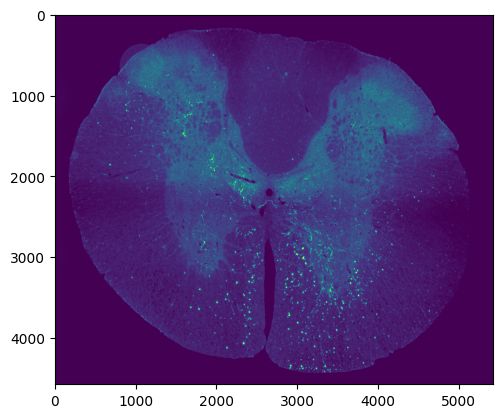

In [21]:
im = plt.imread("Representatives/C1-BJZ5.tif")[:,:,0]
sh = im.shape
plt.imshow(im)
plt.show()

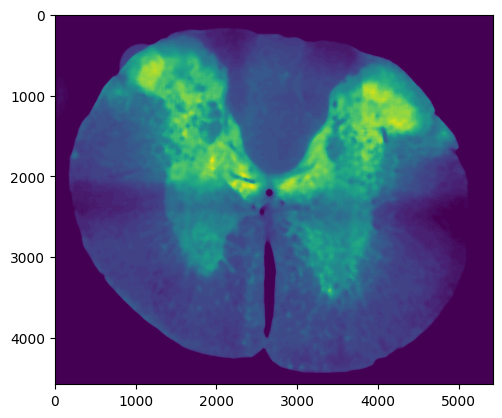

In [22]:
median = cv2.medianBlur(im,65)
plt.imshow(median)

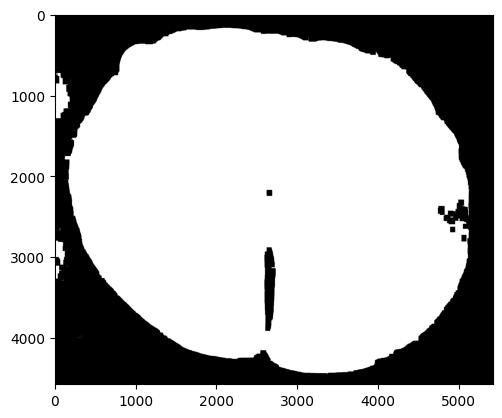

In [23]:
iniital_mask = im > 10
kernel2 = np.ones((60, 60), np.uint8)
iniital_mask = cv2.morphologyEx(iniital_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel2)
show(iniital_mask)

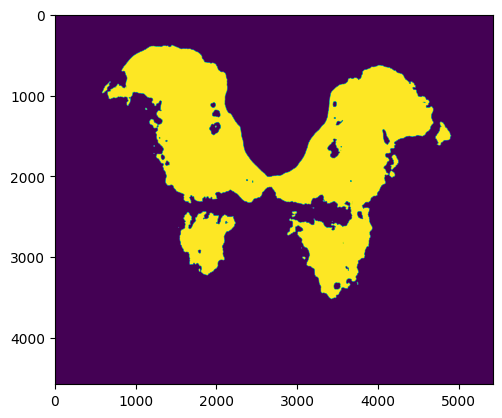

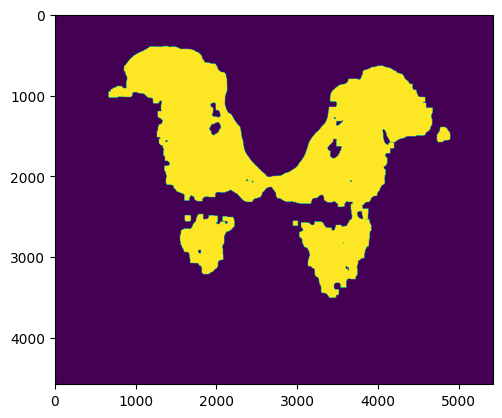

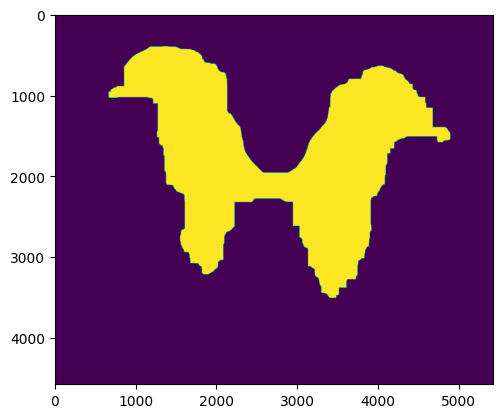

In [24]:
separated = median*iniital_mask
separated = separated[separated > 10]
th = filters.threshold_otsu(separated.flatten())

separated = median*iniital_mask
separated = separated>th

plt.imshow(separated)
plt.show()

kernel2 = np.ones((60, 60), np.uint8)
segmented_open = cv2.morphologyEx(separated.astype(np.uint8), cv2.MORPH_OPEN, kernel2)
plt.imshow(segmented_open)
plt.show()

kernel = np.ones((300,300),np.uint8)
segmented_closed = cv2.morphologyEx(segmented_open.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

plt.imshow(segmented_closed)
plt.show()

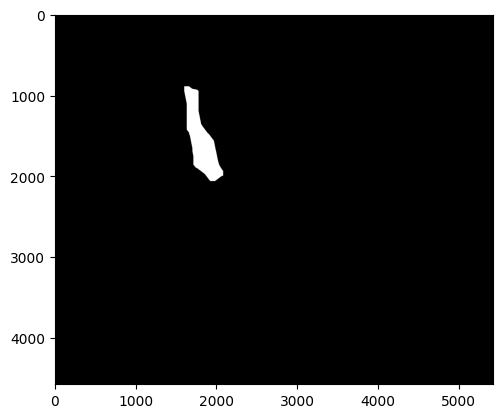

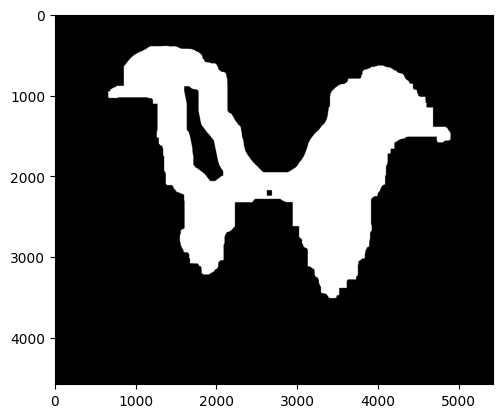

In [25]:
# noise removal
seg = segmented_closed*iniital_mask
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(seg,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
kernel2 = np.ones((30,30),np.uint8)
sure_fg = cv2.morphologyEx(sure_fg,cv2.MORPH_OPEN,kernel2, iterations = 2)

ret, markers = cv2.connectedComponents(sure_fg)

sure_fg_1 = markers==1
show(sure_fg_1)

unknown_1 = sure_fg_1 - sure_bg
show(unknown_1)

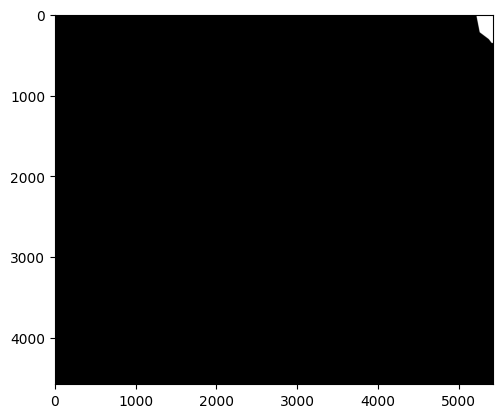

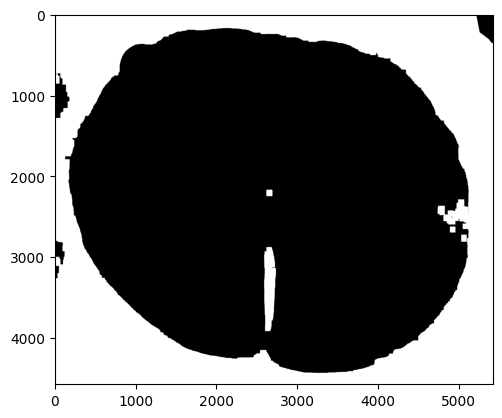

In [26]:
# noise removal
seg = 1-iniital_mask
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(seg.astype(np.uint8),cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
kernel2 = np.ones((30,30),np.uint8)
sure_fg = cv2.morphologyEx(sure_fg,cv2.MORPH_OPEN,kernel2, iterations = 2)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1

sure_fg_0 = markers==2
show(sure_fg_0)

unknown_0 = sure_fg_0 - sure_bg
show(unknown_0)

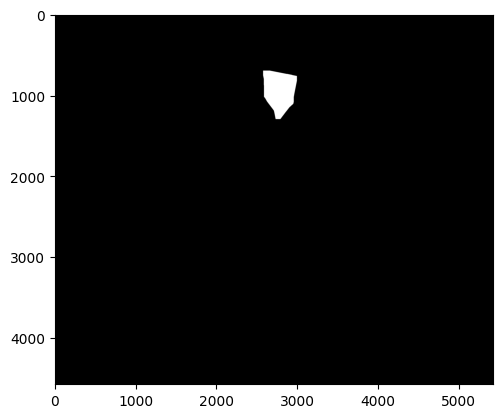

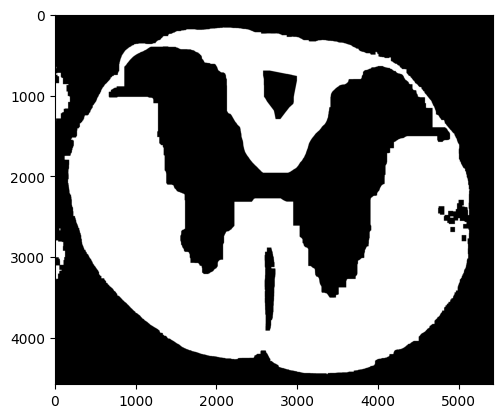

In [27]:
# noise removal
seg = (1-segmented_closed)*iniital_mask
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(seg.astype(np.uint8),cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
kernel2 = np.ones((30,30),np.uint8)
sure_fg = cv2.morphologyEx(sure_fg,cv2.MORPH_OPEN,kernel2, iterations = 2)

unknown = cv2.subtract(sure_bg, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)

sure_fg_2 = markers==1
show(sure_fg_2)

unknown_2 = sure_fg_2 - sure_bg
show(unknown_2)

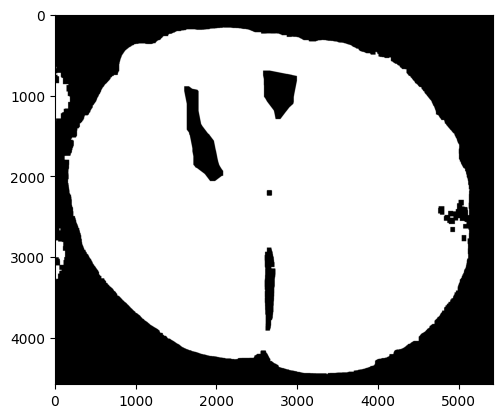

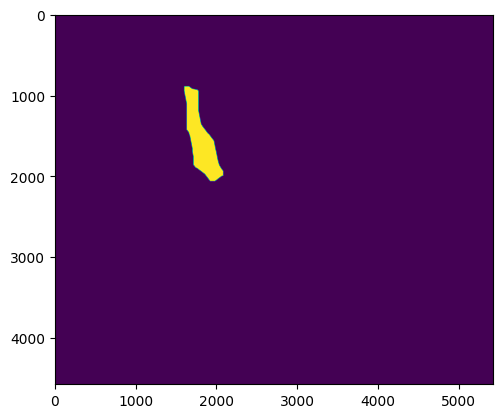

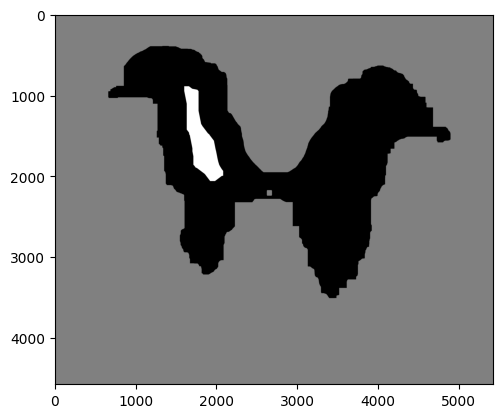

In [28]:
sure_fg = sure_fg_1 + sure_fg_2
unknown = unknown_1 + unknown_2
unknown[unknown==254] = 255
show(unknown)
ret, markers = cv2.connectedComponents(sure_fg_1.astype(np.uint8))
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
plt.imshow(markers)
plt.show()
markers[unknown_1==255] = 0
show(markers)

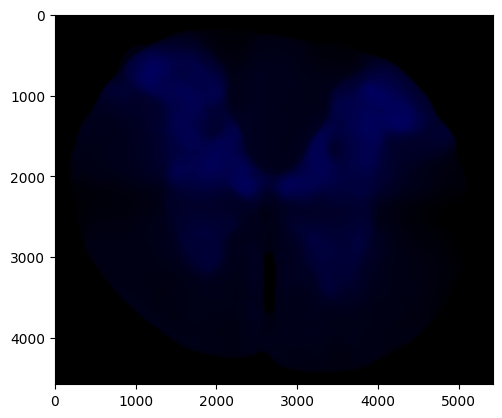

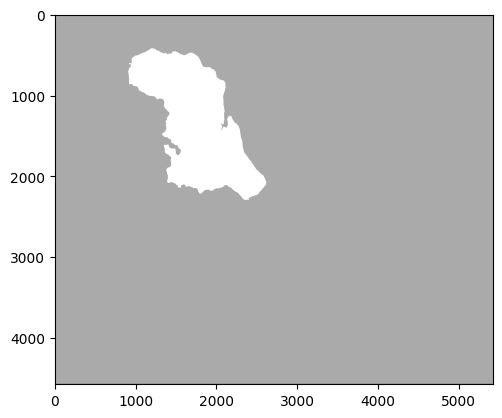

In [30]:
im = cv2.imread("Representatives/C1-BJZ5.tif")
median = cv2.medianBlur(im,205)
show(median)
markers = cv2.watershed(median, markers)
show(markers)

[2 8 6 ... 4 2 4]
Lowval:  2
Highval:  19
[10  8 10 ...  4  2  8]
Lowval:  2
Highval:  101
[ 2  4  6 ...  2  2 17]
Lowval:  10
Highval:  81


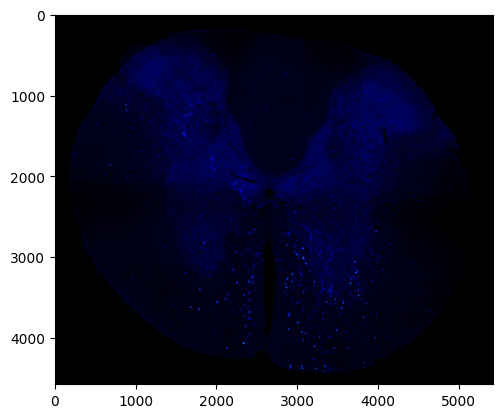

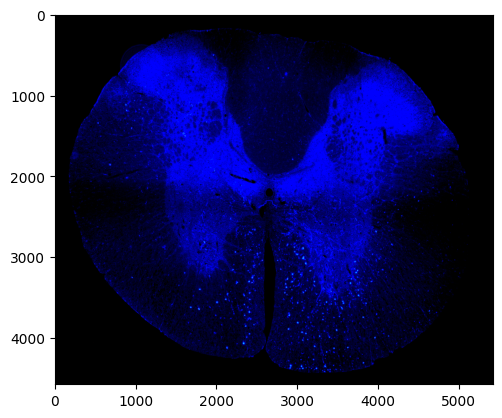

In [32]:
def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1
        flat = flat[flat>0]
        print(flat)
        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[math.floor(n_cols * half_percent)]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))]

        print("Lowval: ", low_val)
        print("Highval: ", high_val)

        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)


img = cv2.imread("Representatives/C1-BJZ5.tif")

out = simplest_cb(img, 15)
plt.imshow(img)
plt.show()
plt.imshow(out)
plt.show()
    

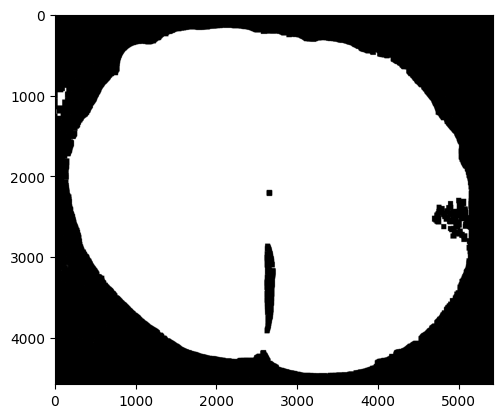

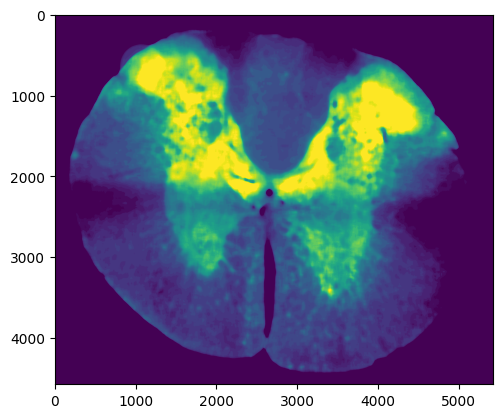

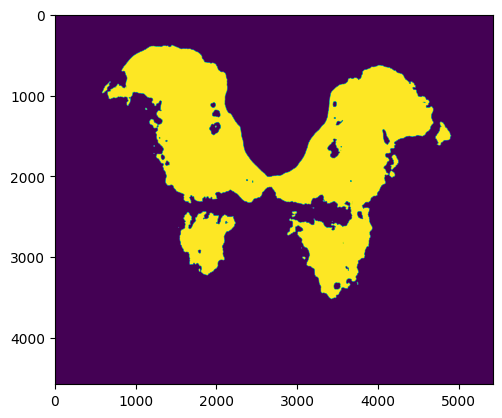

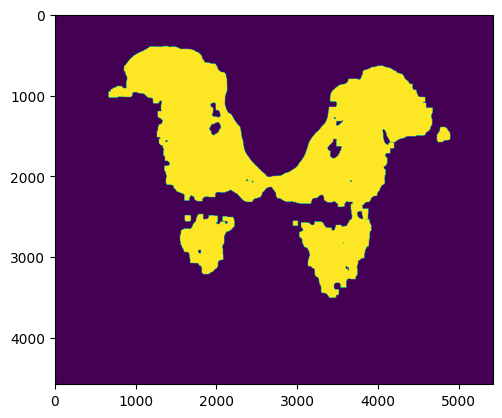

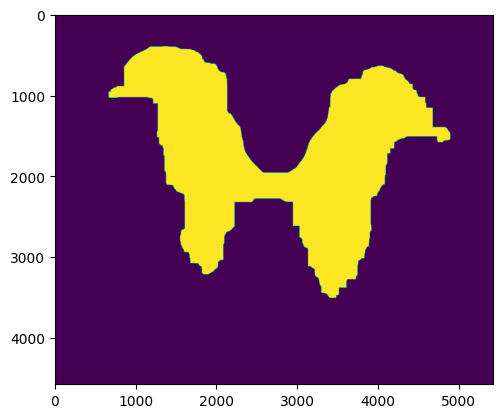

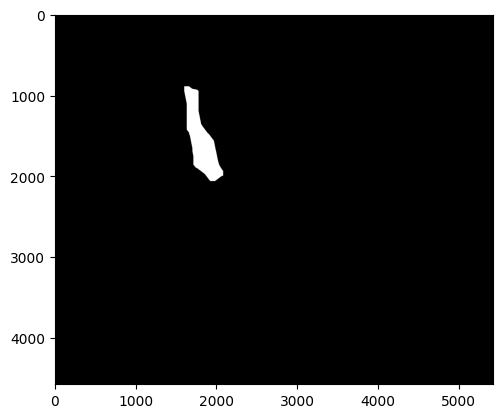

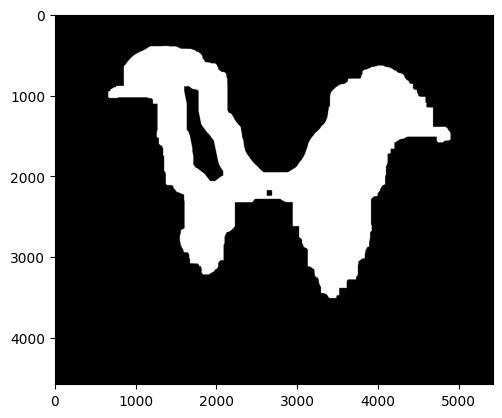

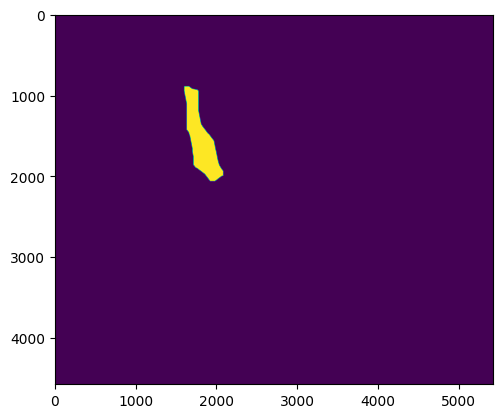

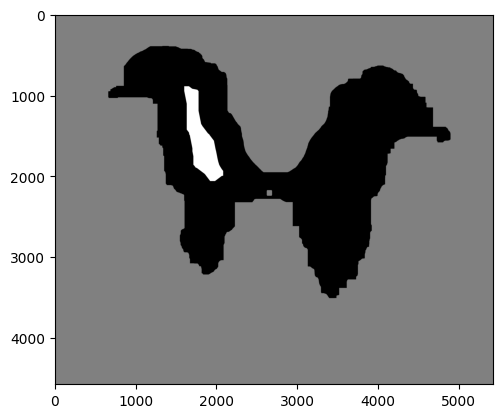

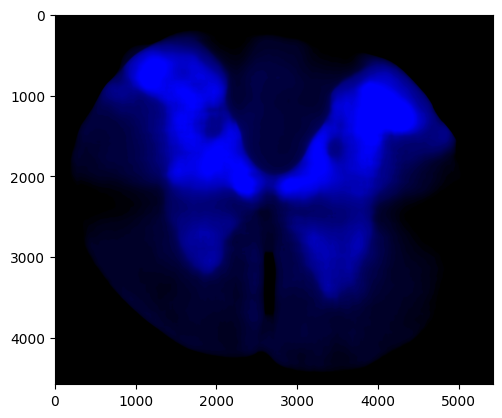

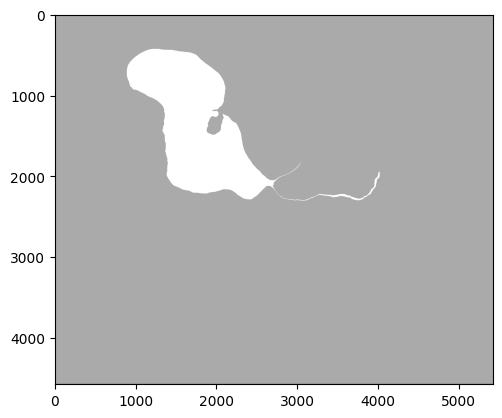

In [34]:
out_gray = out[:,:,2]
iniital_mask = out_gray > 10
kernel2 = np.ones((60, 60), np.uint8)
iniital_mask = cv2.morphologyEx(iniital_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel2)
show(iniital_mask)

median = cv2.medianBlur(out_gray,65)
plt.imshow(median)
plt.show()

separated = median*iniital_mask
separated = separated[separated > 10]
th = filters.threshold_otsu(separated.flatten())

separated = median*iniital_mask
separated = separated>th

plt.imshow(separated)
plt.show()

kernel2 = np.ones((60, 60), np.uint8)
segmented_open = cv2.morphologyEx(separated.astype(np.uint8), cv2.MORPH_OPEN, kernel2)
plt.imshow(segmented_open)
plt.show()

kernel = np.ones((300,300),np.uint8)
segmented_closed = cv2.morphologyEx(segmented_open.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

plt.imshow(segmented_closed)
plt.show()

# noise removal
seg = segmented_closed*iniital_mask
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(seg,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
kernel2 = np.ones((30,30),np.uint8)
sure_fg = cv2.morphologyEx(sure_fg,cv2.MORPH_OPEN,kernel2, iterations = 2)

ret, markers = cv2.connectedComponents(sure_fg)

sure_fg_1 = markers==1
show(sure_fg_1)

unknown_1 = sure_fg_1 - sure_bg
show(unknown_1)


ret, markers = cv2.connectedComponents(sure_fg_1.astype(np.uint8))
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
plt.imshow(markers)
plt.show()
markers[unknown_1==255] = 0
show(markers)

median = cv2.medianBlur(out,205)
show(median)
markers = cv2.watershed(median, markers)
show(markers)

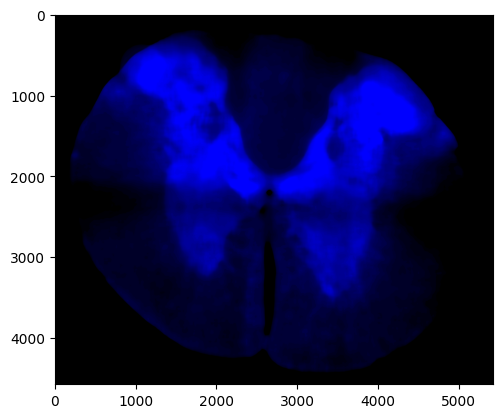

[]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [33]:

median = cv2.medianBlur(out,101)
show(median)
out_med = simplest_cb(median, 15)
show(out_med)
markers = cv2.watershed(out_med, markers)
show(markers)